In [7]:
from helper_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tsai.all import *
import torch
import optuna
from optuna.integration import FastAIPruningCallback
from sklearn.metrics import classification_report
import transformation_funcs as tfs
import seaborn as sns


torch.cuda.set_device(1) 


def snomedConvert(label_df,snomed=True):
    codes =  pd.read_csv("data/codes.csv",sep=";")[["Dx","SNOMED CT Code"]]
    if snomed:
        label_df.columns = [codes[codes["SNOMED CT Code"] == int(x)]["Dx"].item() for x in label_df.columns]
        return label_df
DATASET_NAME = "WFDB_CPSC2018"

In [8]:
X = np.load('./data/big_numpy_datasets/%s.npy'%DATASET_NAME, mmap_mode='c')
label_df = pd.read_csv("data/%s.csv"%DATASET_NAME).drop(columns=["headers","leads"])
y = snomedConvert(label_df)
# get diseases that exist in more than 5 percent of the samples
y=y[y.columns[y.sum()>(0.05*y.shape[0])]]
y.sum()

right bundle branch block       1857
ventricular ectopics             700
atrial fibrillation             1221
1st degree av block              722
premature atrial contraction     616
sinus rhythm                     918
st depression                    869
dtype: int64

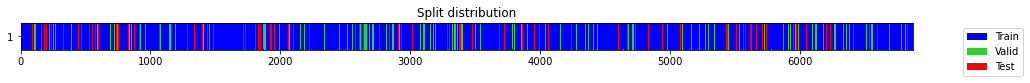

((#5503) [5811,5956,4712,4819,6318,6624,3034,6778,6407,3154...],
 (#687) [1009,3509,2410,802,5922,3599,5541,14,3891,5544...],
 (#687) [1338,984,2725,2906,2389,2232,5590,4461,4559,1005...])

In [9]:
splits = get_splits(y.to_numpy(), valid_size=.1,test_size=0.1, stratify=False, random_state=23, shuffle=True)
splits

In [10]:
# df = pd.read_csv("data/%s.csv"%DATASET_NAME).drop(columns=["headers","leads"])
# y = snomedConvert(y)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))

Counts by label: {'right bundle branch block': 1857, 'sinus rhythm': 918, 'atrial fibrillation': 1221, 'ventricular ectopics': 700, 'st depression': 869, '1st degree av block': 722, 'premature atrial contraction': 616}


In [5]:
# wrap_optimizer()
# torch.optim.Adam()

epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.512672,0.461771,0.894157,0.659745,0.863015,0.328264,0.991227,0.475239,00:06
1,0.426338,0.374933,0.903722,0.693554,0.877075,0.396367,0.990741,0.544852,00:06
2,0.361357,0.322778,0.912248,0.717925,0.913673,0.442911,0.992939,0.594714,00:06
3,0.308266,0.266074,0.919734,0.756094,0.877947,0.524603,0.987585,0.656374,00:06
4,0.266876,0.233610,0.932626,0.796006,0.904974,0.602719,0.989294,0.722683,00:06
5,0.236008,0.213131,0.929299,0.793208,0.880233,0.600540,0.985876,0.712530,00:06
6,0.212456,0.202671,0.935746,0.810231,0.898516,0.632631,0.987831,0.741928,00:06
7,0.200351,0.219345,0.919110,0.775710,0.817910,0.572843,0.978576,0.672728,00:06
8,0.192675,0.203885,0.928883,0.786051,0.891321,0.584028,0.988074,0.705245,00:06
9,0.179761,0.170793,0.939073,0.836472,0.865872,0.691213,0.981731,0.767786,00:06


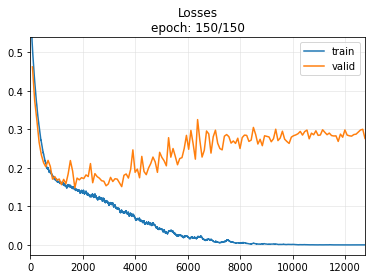

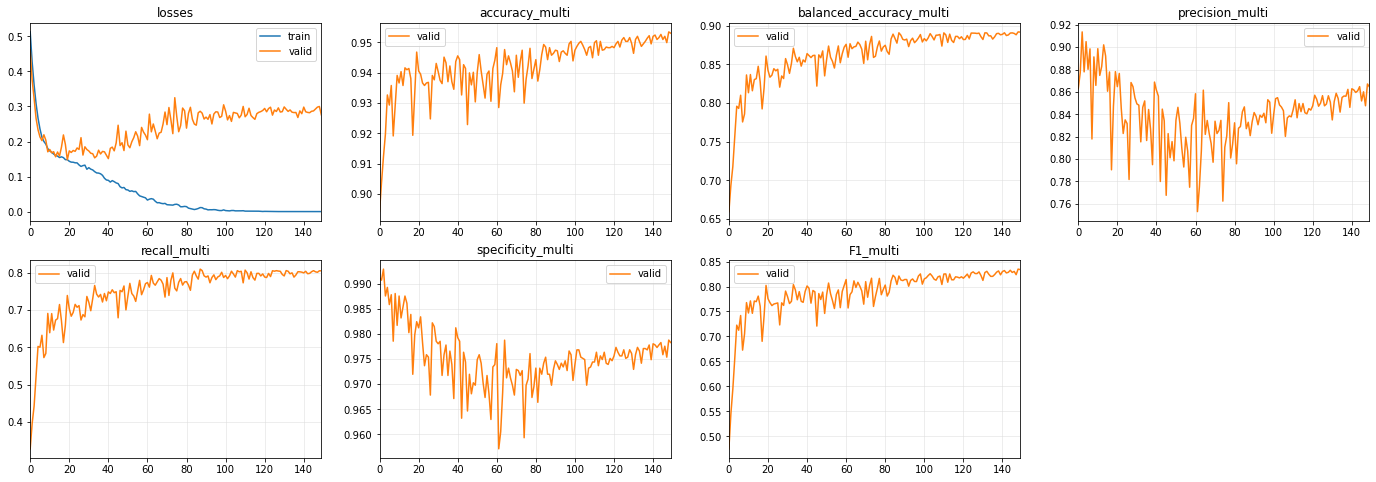

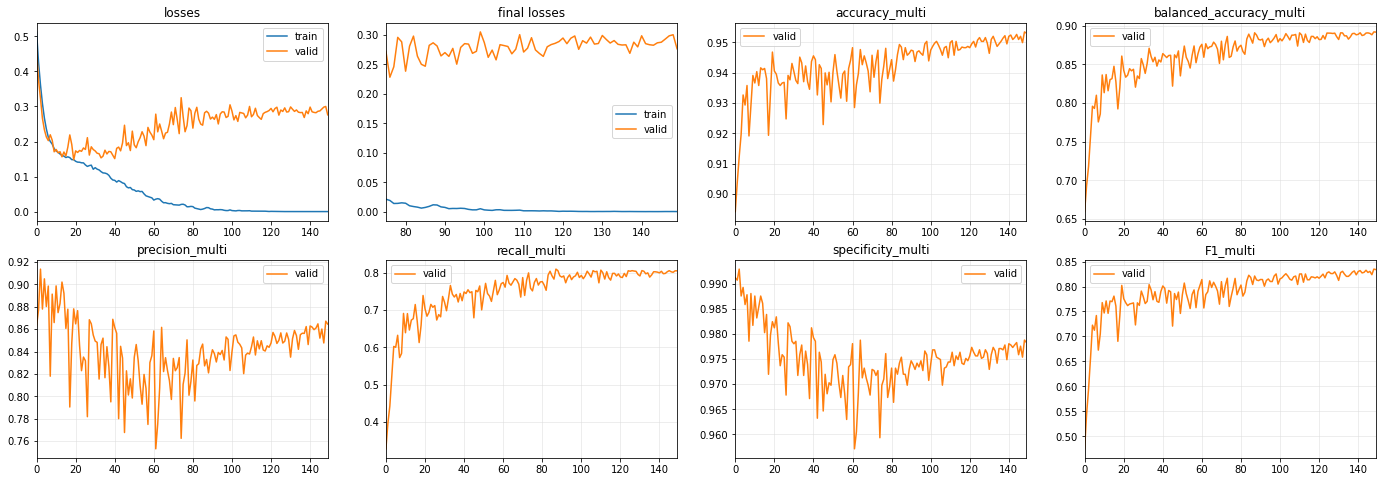

In [11]:
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [TSStandardize(by_sample=True),
              tfs.RandomShift(30),
              tfs.MulNoise(3),
              tfs.CutOut(),
              tfs.Scale(scale_factor=0.5)
             ]
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
# model = MiniRocketPlus(dls.vars, dls.c,2500)
model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=10,)
learn = Learner(dls, model, metrics=metrics, cbs=ShowGraph(),opt_func = wrap_optimizer(torch.optim.Adam,weight_decay=1e-8))
learn.fit_one_cycle(150, lr_max=0.0018562679873326028)
learn.recorder.plot_metrics()

In [12]:
PATH = Path('./models/inception_multilabel_bestparam.pkl')
PATH.parent.mkdir(parents=True, exist_ok=True)
learn.export(PATH)

In [16]:
# tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [TSStandardize(by_sample=True),
#               RandomShift(bp["rand_shift"]),
#               MulNoise(3),
#               tfs.CutOut(),
              tfs.Scale(scale_factor=0.5)
             ]
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=(splits[0],splits[1])) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)

y_pred=np.argmax(valid_preds, axis=1)
y_test=np.argmax(valid_targets, axis=1)

print(classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys()))

                              precision    recall  f1-score   support

         1st degree av block       0.65      0.92      0.76       108
         atrial fibrillation       0.93      0.91      0.92       129
premature atrial contraction       0.59      0.42      0.49        57
   right bundle branch block       0.92      0.94      0.93       175
                sinus rhythm       0.79      0.71      0.75        89
               st depression       0.77      0.74      0.75        77
        ventricular ectopics       0.77      0.52      0.62        52

                    accuracy                           0.80       687
                   macro avg       0.77      0.74      0.75       687
                weighted avg       0.81      0.80      0.80       687

